<a href="https://colab.research.google.com/github/zmarshall4497/dsba/blob/main/Final_Exam_Part_3_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import data set
import pandas as pd
from google.colab import files 
import io

upload = files.upload()

dfZM = pd.read_csv(io.BytesIO(upload['GDP.csv']))


Saving GDP.csv to GDP.csv


In [3]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error

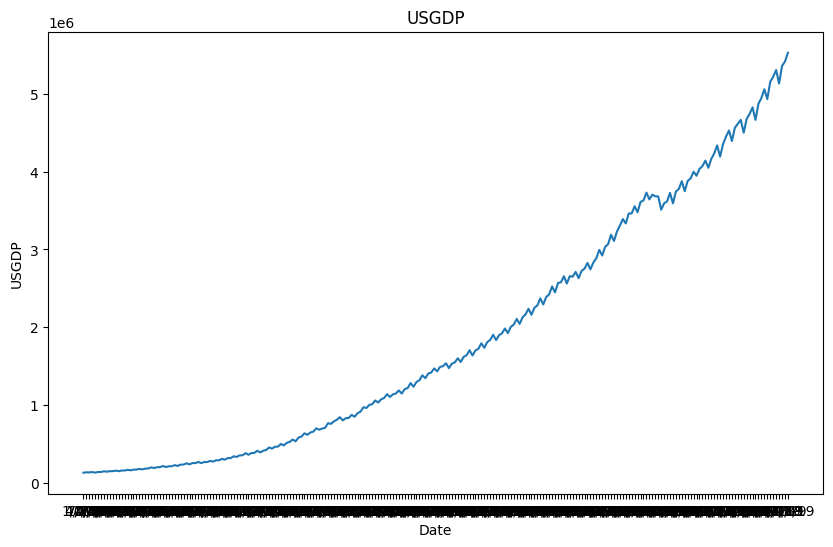

In [5]:
#plot data
plt.figure(figsize=(10,6))
plt.plot(dfZM['DATE'], dfZM['USGDP'])
plt.title('USGDP')
plt.xlabel('Date')
plt.ylabel('USGDP')
plt.show()

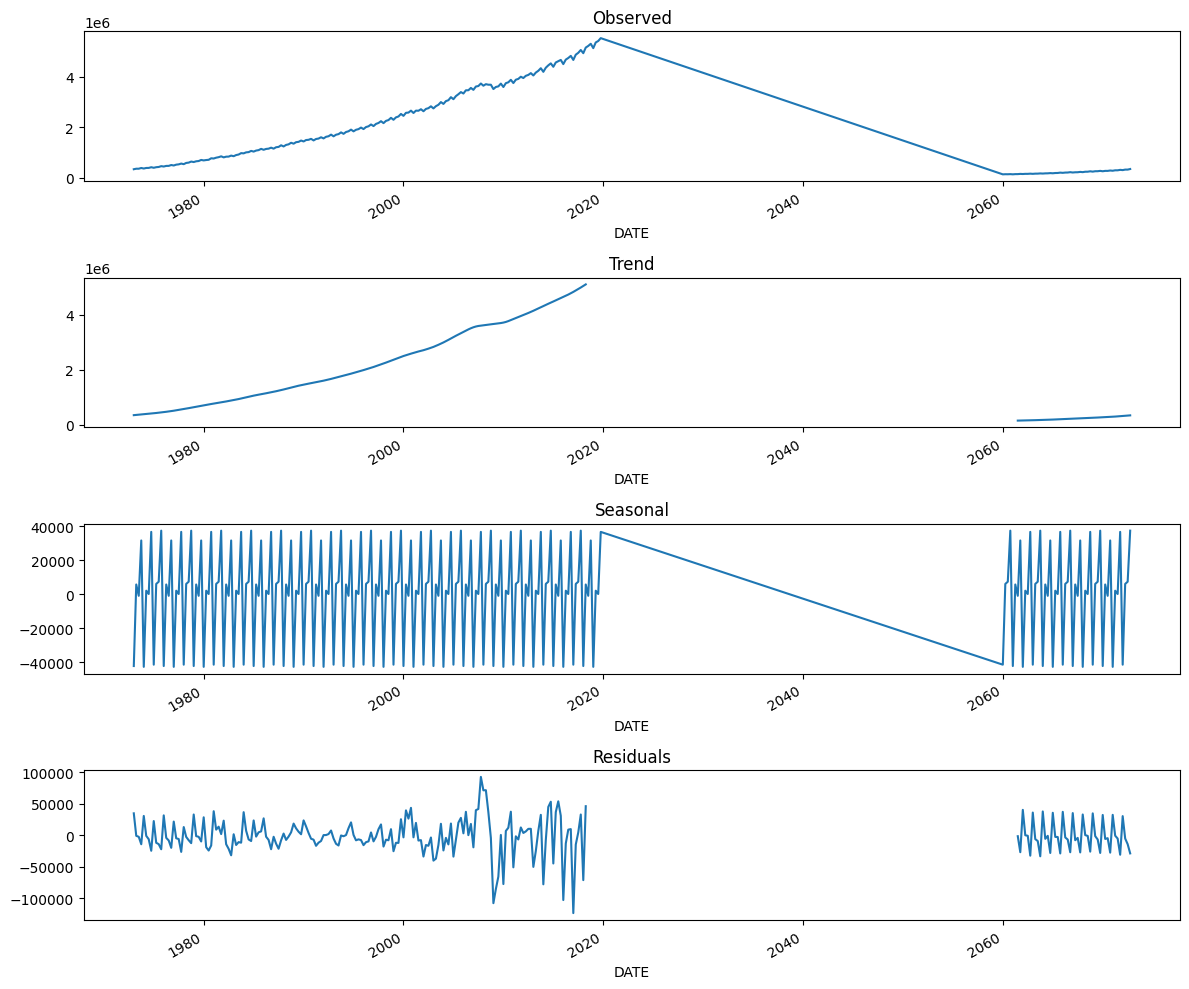

In [6]:
#identify trend and seasonality
# convert DATE column to datetime format and set as index
dfZM['DATE'] = pd.to_datetime(dfZM['DATE'])
dfZM.set_index('DATE', inplace=True)

# seasonal decomposition
result = seasonal_decompose(dfZM['USGDP'], model='additive', period=12)

# plot seasonal decomposition
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10))
result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residuals')
plt.tight_layout()
plt.show()

In [7]:
#Time Series Stationary
# ADF test for stationarity
result = adfuller(dfZM['USGDP'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: 3.9257518356350953
p-value: 1.0
Critical Values:
	1%: -3.4597521044060353
	5%: -2.874472927517147
	10%: -2.5736628197530864


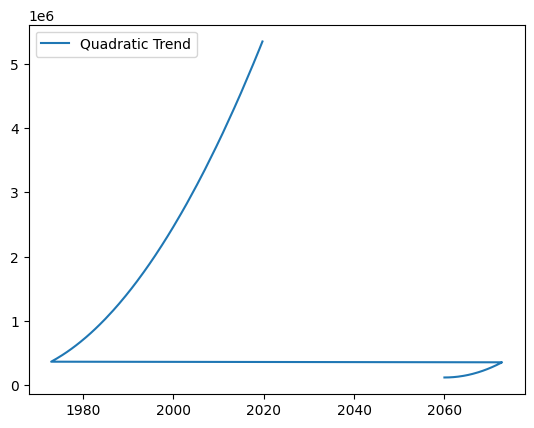

In [16]:
#quadratic trend
# Add quadratic trend
dfZM['time'] = range(1, len(dfZM)+1)
dfZM['time2'] = dfZM['time'] ** 2

# Fit model
model_quad = sm.OLS(dfZM['USGDP'], sm.add_constant(dfZM[['time', 'time2']])).fit()

# Predict values
dfZM['quad_trend'] = model_quad.predict(sm.add_constant(dfZM[['time', 'time2']]))

# Plot quad_trend
plt.plot(dfZM.index, dfZM['quad_trend'], label='Quadratic Trend')
plt.legend(loc='upper left')


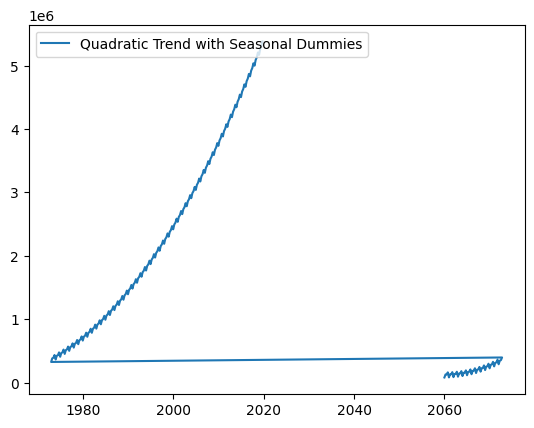

In [17]:
#quadratic trend with seasonal dummies
# Add quadratic trend and seasonal dummies
dfZM['time'] = range(1, len(dfZM)+1)
dfZM['time2'] = dfZM['time'] ** 2
dfZM['month'] = dfZM.index.month
dummies = pd.get_dummies(dfZM['month'], prefix='month')
dfZM = pd.concat([dfZM, dummies], axis=1)

# Fit model
model_quad_seas = sm.OLS(dfZM['USGDP'], sm.add_constant(dfZM[['time', 'time2'] + list(dummies.columns)])).fit()

# Predict values
dfZM['quad_trend_seas'] = model_quad_seas.predict(sm.add_constant(dfZM[['time', 'time2'] + list(dummies.columns)]))

# Plot quad_trend_seas
plt.plot(dfZM.index, dfZM['quad_trend_seas'], label='Quadratic Trend with Seasonal Dummies')
plt.legend(loc='upper left')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ValueError: ignored

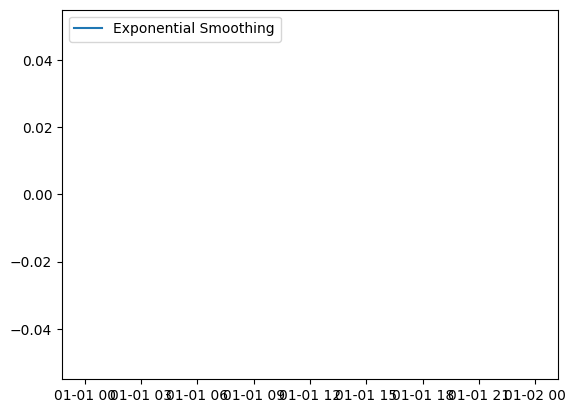

In [21]:
#Simple Exponential Smoothing
train_size = int(len(dfZM) * 0.8) # 80% train, 20% test
train = dfZM['USGDP'][:train_size]
test = dfZM['USGDP'][train_size:]

#Fit model
model_exp = ExponentialSmoothing(train, trend=None, seasonal=None).fit()

#Predict values
dfZM['exp_smooth'] = model_exp.predict(start=train_size, end=len(dfZM)-1)

#Plot exp_smooth
plt.plot(dfZM.index, dfZM['exp_smooth'], label='Exponential Smoothing')
plt.legend(loc='upper left')

#Calculate MAPE
mape_exp = mean_absolute_percentage_error(test, dfZM['exp_smooth'][train_size:])
print(f'MAPE for Exponential Smoothing: {mape_exp}')

#Identify best smoothing parameter
alpha_list = [0.1, 0.3, 0.5, 0.7, 0.9]
mape_list = []
for alpha in alpha_list:
  model_exp = ExponentialSmoothing(train, trend=None, seasonal=None, initialization_method="estimated", smoothing_level=alpha).fit()
pred = model_exp.predict(start=train_size, end=len(dfZM)-1)
mape = mean_absolute_percentage_error(test, pred[train_size:])
mape_list.append(mape)

#Plot MAPE vs alpha
plt.plot(alpha_list, mape_list, 'bo-')
plt.xlabel('Smoothing Parameter (alpha)')
plt.ylabel('MAPE')
plt.title('MAPE vs Smoothing Parameter')
plt.show()

#Print best smoothing parameter
best_alpha = alpha_list[mape_list.index(min(mape_list))]
print(f'Best smoothing parameter: {best_alpha}')